In [2]:
# Importing Libraries
import os,cv2
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [6]:
cv2.setUseOptimized(True);      # optimizing code paths to improve performace
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [8]:
path_test = "C:\\Users\\Advaithaa\\OneDrive\\Desktop\\Spartificial-Internship\\Craters-Dataset\\craters\\test\\images"
annot_test = "C:\\Users\\Advaithaa\\OneDrive\\Desktop\\Spartificial-Internship\\Craters-Dataset\\craters\\test\\labels"

In [10]:
test_labels = []  
test_images = []  
test_bboxes = [] 

In [12]:
def get_iou(bb1, bb2):
    # Assertions are used to confirm that the 2 bounding boxes are properly defined
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # Calculating the intersecting coordinates
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # If this condition is true, the bounding boxes do not overlap, hence IoU 0.0 is returned
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Area of the intersection rectangle is calculated
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Area of both the bounding boxes is calculated
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # IoU score is calculated using the formula intersection area/union
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    # Checking if the IoU is between 0.0 and 1.0
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [14]:
for e, i in enumerate(os.listdir(annot_test)):
    try:
        filename = i.split(".txt")[0] + ".jpg"
        image_path = os.path.join(path_test, filename)
        annotation_path = os.path.join(annot_test, i)
        print(image_path)
        
        # Read the image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Image not found: {image_path}")
            continue
        
        height, width, _ = image.shape

        # Read YOLO annotations
        with open(annotation_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            components = line.strip().split()
            center_x, center_y, bbox_width, bbox_height = map(float, components[1:])

            # Convert YOLO format to bounding box coordinates (in image pixels)
            gtvalues = [
                {"x1": int((center_x - bbox_width / 2) * width),
                 "y1": int((center_y - bbox_height / 2) * height),
                 "x2": int((center_x + bbox_width / 2) * width),
                 "y2": int((center_y + bbox_height / 2) * height),
                 "class_id": int(components[0])  # Assuming components[0] is the class label
                }
            ]

            # Initialize selective search
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()[:1000]  # Get top 1000 regions

            imout = image.copy()
            added_bboxes = set()  # Use a set for faster duplicate checking

            for result in ssresults:
                x, y, w, h = result
                if w < 20 or h < 20:  # Skip very small regions
                    continue

                proposed_bbox = (x, y, x + w, y + h)
                if proposed_bbox in added_bboxes:
                    continue  # Skip duplicates early

                # Calculate IoU with ground truth boxes
                max_iou = 0
                best_gtval = None
                for gtval in gtvalues:
                    iou = get_iou(gtval, {"x1": x, "y1": y, "x2": x + w, "y2": y + h})
                    if iou > max_iou:
                        max_iou = iou
                        best_gtval = gtval

                # Label regions based on IoU
                if max_iou > 0.70:  # True positive
                    label = 1
                elif max_iou < 0.3:  # False positive
                    label = 0
                else:
                    continue  # Ignore uncertain regions

                # Crop, resize, and store the region
                timage = imout[y:y + h, x:x + w]
                resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                test_images.append(resized)

                # Add both class label and bounding box to test_labels
                test_labels.append({
                    'class_id': label,
                    'bbox': [x, y, x + w, y + h]
                })

                test_bboxes.append([x, y, x + w, y + h])  # Store bbox separately if needed for evaluation
                added_bboxes.add(proposed_bbox)  # Track processed bounding boxes

    except Exception as e:
        print(f"Error processing file {i}: {e}")

C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\test\images\010_png.rf.fcf5e274562ee69a325f9d7a0b30767f.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\test\images\015_png.rf.7d5b2091b6339c9480a171a59c52c3b9.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\test\images\019_png.rf.1930cd277f9bf0e3fa57f2dcfee0385f.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\test\images\04_png.rf.81a7d6cbeb9dc09e5a8ecd40e185fc92.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\test\images\mars_crater--100-_jpg.rf.a2ad5867efb2d73e86d9d980ca40a9fe.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\test\images\mars_crater--108-_jpg.rf.9395f473f249e064dbfea078e2519a17.jpg
C:\Users\Advaithaa\OneDrive\Desktop\Spartificial-Internship\Craters-Dataset\craters\test\images\mars_crater--

In [16]:
print("Number of validation images:", len(test_images))
print("Number of classification labels:", len(test_labels))
print("Number of bounding box labels:", len(test_bboxes))

Number of validation images: 79398
Number of classification labels: 79398
Number of bounding box labels: 79398


In [18]:
X_test = np.array(test_images)
# y_test = np.array(test_labels) 

In [38]:
y_test = {
    "classification": np.array([label['class_id'] for label in test_labels]),
    "bbox_regression": np.array(test_bboxes)
}

In [42]:
type(y_test["classification"])

numpy.ndarray

In [44]:
y_test["classification"] = tf.keras.utils.to_categorical((y_test["classification"]), num_classes=2)

In [46]:
y_test["classification"].shape, X_test.shape, y_test["bbox_regression"].shape

((79398, 2), (79398, 224, 224, 3), (79398, 4))

In [50]:
test_bboxes = np.array(test_bboxes)

In [52]:
test_bboxes = test_bboxes / [width, height, width, height]

In [96]:
y_test["bbox_regression"] = (y_test["bbox_regression"]) / [width, height, width, height]

In [138]:
y_test["bbox_regression"].dtype

dtype('float64')

In [140]:
y_test["bbox_regression"] = y_test["bbox_regression"].astype("float32")

In [56]:
from tensorflow.keras.models import load_model

In [160]:
model = load_model('my_best_model.h5')

In [162]:
model.output

{'classification': <KerasTensor shape=(None, 2), dtype=float32, sparse=False, name=keras_tensor_2315>,
 'bbox_regression': <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_2313>}

In [164]:
input_shape = model.input.shape  # This gives (batch_size, height, width, channels)

# Extract height and width
image_height = int(input_shape[1])
image_width = int(input_shape[2])
print(image_height)
print(image_width)

224
224


In [166]:
from tensorflow.keras.losses import CategoricalCrossentropy

categorical_loss = CategoricalCrossentropy(from_logits=False)

In [168]:
def smooth_l1_loss(y_true, y_pred, beta=1.0):
    """
    Compute the Smooth L1 loss, also known as Huber loss.
    Smooth L1 loss transitions between L1 and L2 losses depending on the error magnitude.
    :param y_true: Ground truth bounding boxes, shape (batch_size, 4), [x1, y1, x2, y2]
    :param y_pred: Predicted bounding boxes, shape (batch_size, 4), [x1, y1, x2, y2]
    :param beta: Transition point between L1 and L2 loss, typically set to 1.0
    :return: Smooth L1 loss value
    """
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    y_pred_scaled = y_pred * tf.convert_to_tensor([image_width, image_height, image_width, image_height], dtype=tf.float32)    
    diff = tf.abs(y_true - y_pred)
    loss = tf.where(
        tf.less(diff, beta),
        0.5 * tf.square(diff) / beta,
        diff - 0.5 * beta
    )
    return tf.reduce_mean(loss)


In [170]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=1000,
    decay_rate=0.9
)

In [172]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        "classification": categorical_loss,
        "bbox_regression": smooth_l1_loss,  
    },
    loss_weights={
        "classification": 1.0,
        "bbox_regression": 0.3,  
    },
    metrics={
        "classification": ["accuracy"],
        "bbox_regression": ["mse"],
    },
)

In [174]:
results = model.evaluate(X_test, [ y_test["bbox_regression"], y_test["classification"]], verbose = 1)
print(f"Total Loss: {results[0]}")
print(f"Classification Loss: {results[1]}")
print(f"Bounding Box Regression Loss: {results[2]}")
print(f"Classification Accuracy: {results[3]}")  # Accuracy is the fourth value

y_true shape: (None, 4)
y_pred shape: (None, 4)
y_true shape: (None, 4)
y_pred shape: (None, 4)
2482/2482 ━━━━━━━━━━━━━━━━━━━━ 5346s 2s/step - bbox_regression_loss: 0.0223 - bbox_regression_mse: 0.1490 - classification_accuracy: 0.9976 - classification_loss: 0.0168 - loss: 0.0392
Total Loss: 0.03988732397556305
Classification Loss: 0.022178027778863907
Bounding Box Regression Loss: 0.017708128318190575
Classification Accuracy: 0.14782463014125824


In [176]:
y_pred = model.predict(X_test)  

2482/2482 ━━━━━━━━━━━━━━━━━━━━ 5950s 2s/step


In [180]:
y_pred

{'classification': array([[9.9993110e-01, 6.8873051e-05],
        [9.9997842e-01, 2.1616726e-05],
        [9.9864537e-01, 1.3546926e-03],
        ...,
        [9.9834394e-01, 1.6560093e-03],
        [9.9994063e-01, 5.9327122e-05],
        [9.9962735e-01, 3.7268284e-04]], dtype=float32),
 'bbox_regression': array([[0.22831297, 0.3900383 , 0.34018403, 0.25210828],
        [0.14146598, 0.29602563, 0.16017546, 0.20902535],
        [0.17348519, 0.28562137, 0.15099055, 0.17759982],
        ...,
        [0.20548959, 0.27815774, 0.23245725, 0.2730028 ],
        [0.20637329, 0.34770507, 0.3990077 , 0.33639795],
        [0.23566483, 0.36076573, 0.36118594, 0.37083197]], dtype=float32)}

In [182]:
# y_pred[1] contains the bounding box predictions
y_pred_bboxes = y_pred["bbox_regression"]  # Bounding box predictions, shape = (num_samples, 4)

# Ground truth bounding boxes
y_true_bboxes = y_test["bbox_regression"]

In [184]:
y_pred_class = y_pred['classification']

In [190]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
from tqdm import tqdm

def compute_map(y_true, y_pred, iou_threshold=0.5):
    """
    Compute mean Average Precision (mAP) with a progress bar.

    Args:
        y_true: List of dictionaries with 'boxes' (ground truth boxes) and 'class_id'.
        y_pred: List of dictionaries with 'boxes' (predicted boxes), 'scores', and 'class_id'.
        iou_threshold: IoU threshold for a match.

    Returns:
        Mean Average Precision (mAP).
    """
    def calculate_iou(box1, box2):
        """Calculate IoU between two bounding boxes."""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

        union = area1 + area2 - intersection
        return intersection / union if union > 0 else 0

    aps = []

    # Group by classes
    classes = set(t['class_id'] for t in y_true) | set(p['class_id'] for p in y_pred)
    
    # Use tqdm for progress bar
    for cls in tqdm(classes, desc="Processing Classes", unit="class"):
        # Filter ground truths and predictions by class
        gt_boxes = [t['boxes'] for t in y_true if t['class_id'] == cls]
        pred_boxes = [p['boxes'] for p in y_pred if p['class_id'] == cls]
        pred_scores = [p['scores'] for p in y_pred if p['class_id'] == cls]

        if not gt_boxes or not pred_boxes:
            aps.append(0.0)
            continue

        # Sort predictions by confidence
        sorted_indices = np.argsort(pred_scores)[::-1]
        pred_boxes = np.array(pred_boxes)[sorted_indices]
        pred_scores = np.array(pred_scores)[sorted_indices]

        # Match predictions to ground truths
        matched_gt = set()
        y_true_binary = []
        y_scores = []

        for pred_box, pred_score in zip(pred_boxes, pred_scores):
            # Find best IoU match
            ious = [calculate_iou(pred_box, gt_box) for gt_box in gt_boxes]
            max_iou = max(ious, default=0)
            max_idx = ious.index(max_iou) if max_iou >= iou_threshold else -1

            if max_idx >= 0 and max_idx not in matched_gt:
                y_true_binary.append(1)  # True positive
                matched_gt.add(max_idx)
            else:
                y_true_binary.append(0)  # False positive

            y_scores.append(pred_score)

        # Add false negatives for unmatched ground truths
        unmatched_gt = len(gt_boxes) - len(matched_gt)
        y_true_binary.extend([1] * unmatched_gt)
        y_scores.extend([0] * unmatched_gt)

        # Calculate average precision for the class
        aps.append(average_precision_score(y_true_binary, y_scores))

    # Return mean Average Precision
    return np.mean(aps)


In [228]:
# # Prepare ground truth
# y_true_map = [{'boxes': b, 'class_id': int(np.argmax(c))} for b, c in zip(y_test["bbox_regression"], y_test["classification"])]

# # Prepare predictions
# y_pred_map = [
#     {'boxes': b, 'scores': float(max(s)), 'class_id': int(np.argmax(s))}
#     for b, s in zip(y_pred_bboxes, y_pred_class)
# ]
# print(f"Number of ground truth boxes: {len(y_true_map)}")
# print(f"Number of predicted boxes: {len(y_pred_map)}")
# y_true_subset = y_true_map[:3000]  
# y_pred_subset = y_pred_map[:3000]
# print(f"Number of ground truth boxes in subset: {len(y_true_subset)}")
# print(f"Number of predicted boxes in subset: {len(y_pred_subset)}")
# # Compute mAP score
# map_score = compute_map(y_true_subset, y_pred_subset, iou_threshold=0.7)
# print(f"mAP Score (IoU threshold 0.5): {map_score}")

In [208]:
import torch

In [248]:
# def nms_pytorch(P: torch.tensor, thresh_iou: float):
#     """
#     Apply non-maximum suppression to avoid detecting too many
#     overlapping bounding boxes for a given object.

#     Args:
#         P: (tensor) The location predictions for the image 
#             along with the class prediction scores, Shape: [num_boxes, 5].
#             The tensor P contains bounding box coordinates and their corresponding confidence scores.
#         thresh_iou: (float) The overlap threshold for suppressing unnecessary boxes.

#     Returns:
#         A list of filtered boxes, Shape: [ , 5]
#     """

#     # Extract the coordinates for every prediction box in P (top-left and bottom-right)
#     x_min = P[:, 0]
#     y_min = P[:, 1]
#     x_max = P[:, 2]
#     y_max = P[:, 3]

#     # Extract the confidence scores
#     scores = P[:, 4]

#     # Calculate the area of each bounding box
#     areas = (x_max - x_min) * (y_max - y_min)

#     # Sort the prediction boxes according to their confidence scores (descending order)
#     order = scores.argsort()

#     # Initialize an empty list for filtered prediction boxes
#     keep = []

#     while len(order) > 0:
#         # Get the index of the prediction with the highest score
#         idx = order[-1]

#         # Add the selected prediction to the filtered list
#         keep.append(P[idx])

#         # Remove the selected prediction from the list
#         order = order[:-1]

#         # If no more predictions remain, stop
#         if len(order) == 0:
#             break

#         # Calculate IoU between the remaining boxes and the selected box (idx)
#         xx_min = torch.index_select(x_min, dim=0, index=order)
#         yy_min = torch.index_select(y_min, dim=0, index=order)
#         xx_max = torch.index_select(x_max, dim=0, index=order)
#         yy_max = torch.index_select(y_max, dim=0, index=order)

#         # Find the coordinates of the intersection boxes
#         xx_min = torch.max(xx_min, x_min[idx])
#         yy_min = torch.max(yy_min, y_min[idx])
#         xx_max = torch.min(xx_max, x_max[idx])
#         yy_max = torch.min(yy_max, y_max[idx])

#         # Calculate the width and height of the intersection boxes
#         w = xx_max - xx_min
#         h = yy_max - yy_min

#         # Ensure non-negative width and height (for non-overlapping boxes)
#         w = torch.clamp(w, min=0.0)
#         h = torch.clamp(h, min=0.0)

#         # Calculate the intersection area
#         inter = w * h

#         # Get the areas of the remaining boxes
#         rem_areas = torch.index_select(areas, dim=0, index=order)

#         # Calculate the union area (union = area1 + area2 - intersection)
#         union = (rem_areas - inter) + areas[idx]

#         # Calculate the IoU for each remaining box
#         IoU = inter / union

#         # Keep the boxes with IoU less than the threshold
#         mask = IoU < thresh_iou
#         order = order[mask]

#     return keep


In [250]:
# prediction_boxes_with_scores = [
#     {"bbox": bbox, "confidence": confidence}
#     for bbox, confidence in zip(y_pred_bboxes, y_pred_class)
# ]

# # Combine bounding boxes and scores into a tensor for NMS
# # Each row is [x_min, y_min, x_max, y_max, confidence]
# P = torch.tensor([
#     np.concatenate([pred['bbox'], np.array([max(pred['confidence'])])], axis=0)  # Concatenate bbox and confidence correctly
#     for pred in prediction_boxes_with_scores
# ], dtype=torch.float32) # Convert everything to a float tensor

# confidence_threshold = 0.3  
# P = P[P[:, 4] > confidence_threshold]

# # Apply NMS to the predictions (using IoU threshold of 0.5, for example)
# thresh_iou = 0.3
# nms_output = nms_pytorch(P, thresh_iou)

# # Convert NMS output back into a list of predictions with filtered boxes and scores
# filtered_predictions = [{"bbox": pred[:4].tolist(), "confidence": pred[4].item()} for pred in nms_output]

# # Assuming y_val and val_bboxes_small are available for the ground truth
# y_true_map = [{'boxes': b, 'class_id': int(np.argmax(c))} for b, c in zip(y_test["bbox_regression"], y_test["classification"])]

# # Prepare predicted boxes and scores for mAP calculation
# y_pred_map1 = [
#     {'boxes': p['bbox'], 'scores': p['confidence'], 'class_id': int(np.argmax(p['confidence']))}  # Confidence to class_id
#     for p in filtered_predictions
# ]
# print(f"Before NMS: {len(y_pred_bboxes)} predictions")
# print(f"After NMS: {len(filtered_predictions)} predictions")
# y_true_subset = y_true_map[:3000]  
# y_pred1_subset = y_pred_map1[:3000]
# print(f"Number of ground truth boxes in subset: {len(y_true_subset)}")
# print(f"Number of predicted boxes in subset: {len(y_pred1_subset)}")
# # Compute mAP score
# map_score = compute_map(y_true_subset, y_pred1_subset, iou_threshold=0.5)
# print(f"mAP Score (after NMS): {map_score}")

In [238]:
def nms_per_object(P: torch.tensor, iou_threshold: float):
    """
    Apply NMS to retain the highest-confidence box for each object.

    Args:
        P: (tensor) Bounding boxes with scores, Shape: [num_boxes, 5].
           Each row is [x_min, y_min, x_max, y_max, confidence].
        iou_threshold: (float) IoU threshold for grouping boxes into the same object.

    Returns:
        Tensor containing filtered bounding boxes, Shape: [num_objects, 5].
    """
    if P.shape[0] == 0:
        return torch.empty((0, 5))  # Return an empty tensor if no predictions exist

    # Extract box coordinates and confidence scores
    x_min, y_min, x_max, y_max, scores = P[:, 0], P[:, 1], P[:, 2], P[:, 3], P[:, 4]

    # Calculate box areas
    areas = (x_max - x_min) * (y_max - y_min)

    # Sort boxes by confidence scores (descending order)
    order = scores.argsort(descending=True)

    keep = []  # List of indices for boxes to keep

    while order.numel() > 0:
        # Take the box with the highest score
        idx = order[0]
        keep.append(idx)

        # Calculate IoU of the highest-scoring box with the remaining boxes
        xx_min = torch.max(x_min[idx], x_min[order[1:]])
        yy_min = torch.max(y_min[idx], y_min[order[1:]])
        xx_max = torch.min(x_max[idx], x_max[order[1:]])
        yy_max = torch.min(y_max[idx], y_max[order[1:]])

        # Calculate intersection
        w = torch.clamp(xx_max - xx_min, min=0)
        h = torch.clamp(yy_max - yy_min, min=0)
        intersection = w * h

        # Calculate union and IoU
        remaining_areas = areas[order[1:]]
        union = remaining_areas + areas[idx] - intersection
        iou = intersection / union

        # Keep only boxes with IoU below the threshold
        order = order[1:][iou < iou_threshold]

    # Return the highest-confidence boxes
    return P[keep]


In [246]:
# Combine bounding boxes and scores into a tensor for NMS
prediction_boxes_with_scores = [
    {"bbox": bbox, "confidence": confidence}
    for bbox, confidence in zip(y_pred_bboxes, y_pred_class)
]

P = torch.tensor([
    np.concatenate([pred['bbox'], np.array([max(pred['confidence'])])], axis=0)  # Concatenate bbox and confidence correctly
    for pred in prediction_boxes_with_scores
], dtype=torch.float32)  # Convert everything to a float tensor

# Apply confidence threshold to filter low-confidence predictions
confidence_threshold = 0.8  # Use a stricter threshold
P = P[P[:, 4] > confidence_threshold]

# Apply NMS to keep only one prediction per object
iou_threshold = 0.1  # Use a stricter IoU threshold for object grouping
nms_output = nms_per_object(P, iou_threshold)

# Convert NMS output back into a list of predictions with filtered boxes and scores
filtered_predictions = [{"bbox": pred[:4].tolist(), "confidence": pred[4].item()} for pred in nms_output]

# Prepare ground truth and predictions for mAP calculation
y_true_map = [{'boxes': b, 'class_id': int(np.argmax(c))} for b, c in zip(y_test["bbox_regression"], y_test["classification"])]
y_pred_map1 = [
    {'boxes': p['bbox'], 'scores': p['confidence'], 'class_id': 0}  # Single highest-confidence box; assumes class_id is 0
    for p in filtered_predictions
]

# Subset data for mAP calculation
y_true_subset = y_true_map[:3000]
y_pred1_subset = y_pred_map1[:3000]

print(f"Before NMS: {len(y_pred_bboxes)} predictions")
print(f"After NMS: {len(filtered_predictions)} predictions")

# Compute mAP score
map_score = compute_map(y_true_subset, y_pred1_subset, iou_threshold=0.1)
print(f"mAP Score (after NMS): {map_score}")


Before NMS: 79398 predictions
After NMS: 55558 predictions


Processing Classes: 100%|██████████| 2/2 [00:45<00:00, 22.93s/class]

mAP Score (after NMS): 0.24910021559868134


In [286]:
type(y_true_subset[3])

dict

In [360]:
y_pred1_subset

[{'boxes': [0.16400666534900665,
   0.20946866273880005,
   0.3276298940181732,
   0.24231374263763428],
  'scores': 1.0,
  'class_id': 0},
 {'boxes': [0.20546795427799225,
   0.2438032329082489,
   0.4383062422275543,
   0.2651849091053009],
  'scores': 1.0,
  'class_id': 0},
 {'boxes': [0.2004484087228775,
   0.05560649558901787,
   0.16169902682304382,
   0.21840500831604004],
  'scores': 1.0,
  'class_id': 0},
 {'boxes': [0.22786134481430054,
   0.3661811053752899,
   0.3640468716621399,
   0.20000667870044708],
  'scores': 1.0,
  'class_id': 0},
 {'boxes': [0.14601954817771912,
   -0.04422346502542496,
   0.10127636045217514,
   0.03892595320940018],
  'scores': 1.0,
  'class_id': 0},
 {'boxes': [-0.1741785854101181,
   0.24486131966114044,
   0.42849797010421753,
   0.17901591956615448],
  'scores': 1.0,
  'class_id': 0},
 {'boxes': [0.03489348292350769,
   0.1603901982307434,
   0.26571914553642273,
   0.44452714920043945],
  'scores': 1.0,
  'class_id': 0},
 {'boxes': [-0.17417

In [274]:
from sklearn.metrics import precision_recall_curve

In [366]:
def plot_precision_recall(y_true_map, y_pred_map, iou_threshold=0.5, save_path=None):
    """
    Plots the Precision-Recall curve for filtered predictions of a specific image.
    Assumes that y_true_map and y_pred_map are for the same image.

    Args:
        y_true_map (list): List of dictionaries with 'boxes' (ground truth boxes), 'class_id'.
        y_pred_map (list): List of dictionaries with 'boxes' (predicted boxes), 'scores', and 'class_id'.
        iou_threshold (float): IoU threshold to consider a prediction as a match.
        save_path (str): Path to save the plot. If None, the plot will be shown but not saved.

    Returns:
        None: Displays the plot and optionally saves it to a file.
    """
    def calculate_iou(box1, box2):
        """Calculate IoU between two bounding boxes."""
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])

        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

        union = area1 + area2 - intersection
        return intersection / union if union > 0 else 0

    y_true_binary = []
    y_scores = []

    for pred in y_pred_map:
        pred_box = pred['boxes']
        pred_score = pred['scores']

        # Match the prediction with ground truths
        ious = [calculate_iou(pred_box, gt['boxes']) for gt in y_true_map if gt['class_id'] == pred['class_id']]
        max_iou = max(ious, default=0)

        if max_iou >= iou_threshold:
            y_true_binary.append(1)  # True positive
        else:
            y_true_binary.append(0)  # False positive

        y_scores.append(pred_score)

    # Ensure there's enough data for the precision-recall curve
    if len(y_true_binary) == 0 or len(y_scores) == 0:
        print("Insufficient data for precision-recall curve for this image.")
        return

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true_binary, y_scores)
    average_precision = average_precision_score(y_true_binary, y_scores)

    # Plot the curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color='b')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)
        print(f"Precision-Recall curve saved to {save_path}")
    else:
        print("No path given")  
    plt.show()

Precision-Recall curve saved to precision_recall_curve.png


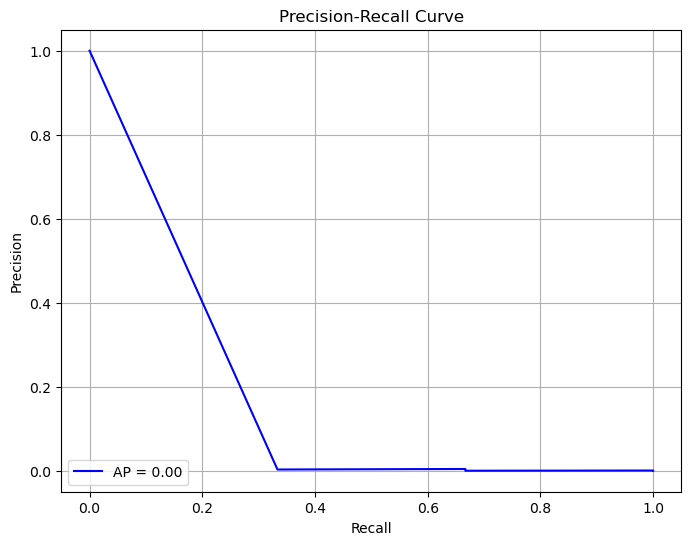

In [368]:
plot_precision_recall(y_true_subset, y_pred1_subset, iou_threshold=0.5, save_path='precision_recall_curve.png')

In [348]:
import matplotlib.patches as patches

Figure saved to test_image_result.png


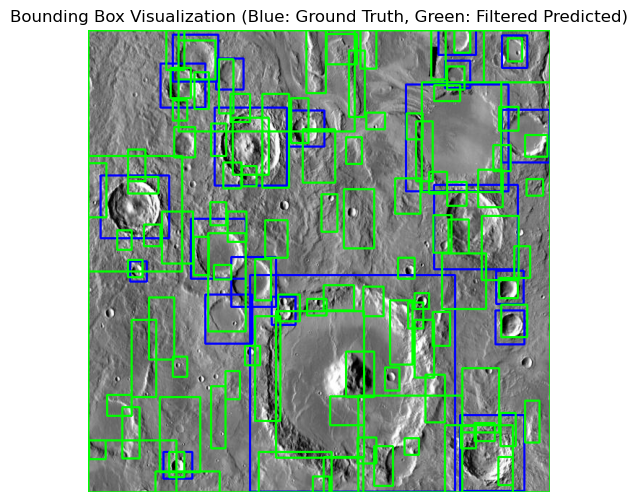

In [364]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to visualize bounding boxes using cv2.rectangle
def visualize_bounding_boxes(image, ground_truths, filtered_bboxes, save_path = None):
    """
    Visualize ground truth and filtered bounding boxes on an image using cv2.rectangle.

    Parameters:
    - image: The original image (BGR format from cv2).
    - ground_truths: List of ground truth bounding boxes as dictionaries with keys 'x1', 'y1', 'x2', 'y2'.
    - filtered_bboxes: List of filtered bounding boxes after NMS with confidence scores.
    """
    image_copy = image.copy()  # Make a copy of the image to draw on

    # Draw ground truth boxes in blue
    for gt in ground_truths:
        cv2.rectangle(image_copy, (gt['x1'], gt['y1']), (gt['x2'], gt['y2']), (255, 0, 0), 2)  # Blue (BGR)
    
    # Draw filtered bounding boxes (after NMS) in green
    for bbox in filtered_bboxes:
        color = (0, 255, 0)  # Green (for the filtered predictions)
        cv2.rectangle(image_copy, (int(bbox['bbox'][0]), int(bbox['bbox'][1])), 
                       (int(bbox['bbox'][2]), int(bbox['bbox'][3])), color, 2)

    # Convert image to RGB for displaying using matplotlib
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title("Bounding Box Visualization (Blue: Ground Truth, Green: Filtered Predicted)")
    plt.axis("off")
    

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  
        print(f"Figure saved to {save_path}")
    else:
        print("No path given")
    plt.show()
# Apply NMS and visualize
visualized_count = 0  # Counter to track the number of visualized images
max_visualizations = 1  # Number of images to visualize

# Process and visualize images
for e, i in enumerate(os.listdir(annot_test)):
    try:
        if visualized_count >= max_visualizations:
            break  # Stop after visualizing the specified number of images
        
        filename1 = i.split(".txt")[0] + ".jpg"
        image_path_test = os.path.join(path_test, filename1)
        annotation_path_test = os.path.join(annot_test, i)

        image_test = cv2.imread(image_path_test)
        if image_test is None:
            print(f"Image not found: {image_path_test}")
            continue

        height1, width1, _ = image_test.shape

        with open(annotation_path_test, 'r') as f:
            lines1 = f.readlines()

        # Parse the ground truth bounding boxes from the annotation file
        gtvalues1 = []
        for line1 in lines1:
            components1 = line1.strip().split()

            # Ensure the line contains valid components
            if len(components1) < 4:
                print(f"Invalid line in {i}: {line1}")
                continue

            try:
                center_x1, center_y1, bbox_width1, bbox_height1 = map(float, components1[1:])
                x1 = int((center_x1 - bbox_width1 / 2) * width1)
                x2 = int((center_x1 + bbox_width1 / 2) * width1)
                y1 = int((center_y1 - bbox_height1 / 2) * height1)
                y2 = int((center_y1 + bbox_height1 / 2) * height1)

                # Store the ground truth box as a dictionary
                gtvalues1.append({"x1": x1, "y1": y1, "x2": x2, "y2": y2})
            except ValueError as ve:
                print(f"Error parsing line in {i}: {line1}")
                continue

        # Perform selective search to propose bounding boxes
        ss.setBaseImage(image_test)
        ss.switchToSelectiveSearchFast()
        ssresults1 = ss.process()[:1000]

        added_bboxes_test = set()
        prediction_boxes_with_scores = []

        # Loop through the proposed bounding boxes and classify them
        for result1 in ssresults1:
            x_val, y_val, w_val, h_val = result1
            if w_val < 20 or h_val < 20:
                continue

            proposed_bbox_test = (x_val, y_val, x_val + w_val, y_val + h_val)

            # Store the bounding box 
            confidence_score = 0.9  
            prediction_boxes_with_scores.append({"bbox": proposed_bbox_test, "confidence": confidence_score})

        # Combine bounding boxes and scores into a tensor for NMS
        P = torch.tensor([
            np.concatenate([pred['bbox'], np.array([pred['confidence']])], axis=0)  # Concatenate bbox and confidence
            for pred in prediction_boxes_with_scores
        ], dtype=torch.float32)

        confidence_threshold = 0.3  
        P = P[P[:, 4] > confidence_threshold]  # Apply the confidence threshold

        # Apply NMS to the predictions 
        thresh_iou = 0.1
        nms_output = nms_per_object(P, thresh_iou)

        # Convert NMS output back into a list of predictions with filtered boxes and scores
        filtered_predictions = [{"bbox": pred[:4].tolist(), "confidence": pred[4].item()} for pred in nms_output]

        # Call visualization function with NMS filtered bounding boxes
        visualize_bounding_boxes(image_test, gtvalues1, filtered_predictions,save_path='test_image_result.png')

        visualized_count += 1  # Increment the counter after visualizing an image

    except Exception as e:
        print(f"Error processing file {i}: {e}")
